In [1]:
import wfdb
import matplotlib.pyplot as plt
from scipy import signal
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
import os

In this model we work in the frequency domain.

Below we show the motivation. The first set of plots shows a clean signal and its respective spectrogram. The second set of plot is from a noisy one. A clear visual distinction exists.

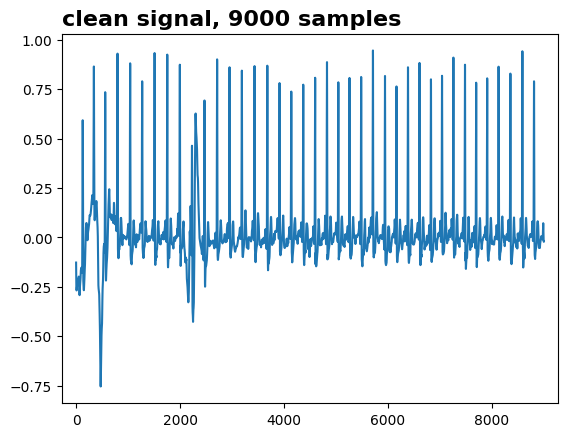

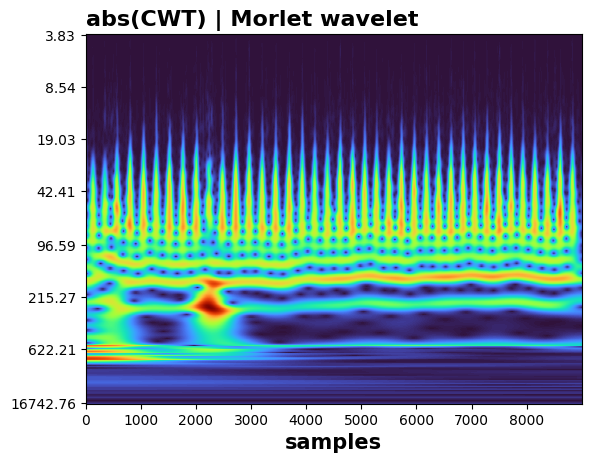

In [2]:
clean, info = wfdb.rdsamp('./data/training2017/A00001')
Wx, scales = cwt(clean[:,0], 'morlet')
plot(clean[:,0], title="clean signal, %s samples" % len(clean[:,0]), show=1)
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet", xlabel="samples")

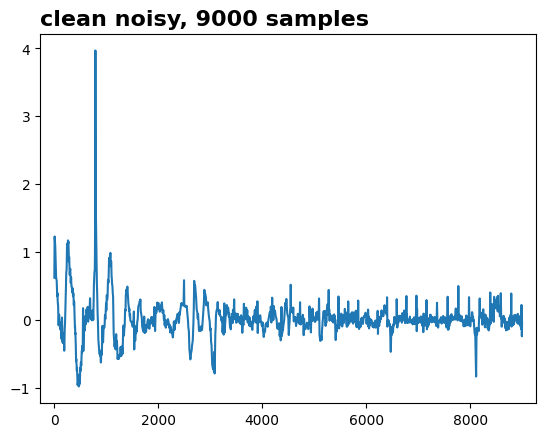

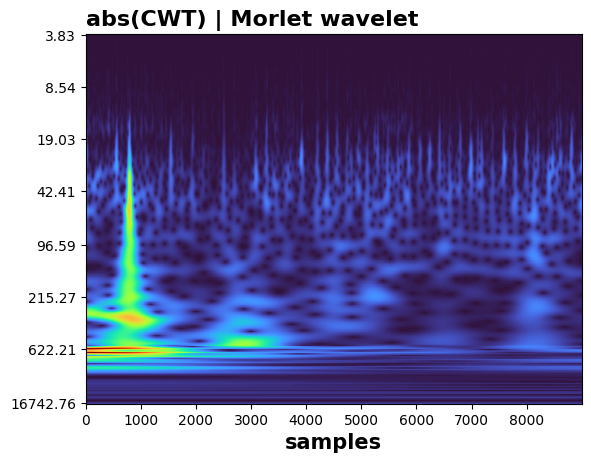

In [3]:
noisy, info = wfdb.rdsamp('./data/training2017/A00022')
Wx, scales = cwt(noisy[:,0], 'morlet')
plot(noisy[:,0], title="clean noisy, %s samples" % len(noisy[:,0]), show=1)
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet", xlabel="samples")

In [4]:
def rollingWindow(a, window, step=1):
    shape = a.shape[:-1] + ((a.shape[-1] - window + 1)//step, window)
    strides = (a.strides[0] * step,) + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [5]:
MIN_BPM = 30
MIN_FREQ = 300  # from inspection of '.hea' content
SAMPLE_WINDOW = int(60 / MIN_BPM * MIN_FREQ)
FIRST_WINDOW = int(SAMPLE_WINDOW / 2)  # avoid artifacts in the beginning of signal

In [6]:
t17 = pd.read_csv('./data/training2017/REFERENCE.csv', names=['id', 'type'])
t17['fname'] = './data/training2017/' + t17.id
t17['noisy'] = t17.type == '~'

saa = pd.read_csv('./data/set-a/RECORDS-acceptable', names=['id'])
saa['fname'] = './data/set-a/' + saa.id.astype(str)
saa['noisy'] = False
sau = pd.read_csv('./data/set-a/RECORDS-unacceptable', names=['id'])
sau['fname'] = './data/set-a/' + sau.id.astype(str)
sau['noisy'] = True
sa = pd.concat([saa, sau])

val = pd.read_csv('./data/validation/REFERENCE.csv', names=['id', 'type'])
val['fname'] = './data/validation/' + val.id
val['noisy'] = val.type == '~'

Below we perform the same preprocessing as was done in [ecgV1.ipynb](./ecgV1.ipynb).

In [7]:
train_validate_noisy = []
train_validate_clean = []

for idx, row in t17.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_wnd = rollingWindow(sgnl[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 3)])
        if row['noisy']:
            train_validate_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            train_validate_clean.append(sgnl_wnd[sgnl_picks])
for idx, row in sa.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_ds = signal.resample(sgnl, int(len(sgnl) / info['fs'] * MIN_FREQ))
        sgnl_wnd = rollingWindow(sgnl_ds[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 3)])
        if row['noisy']:
            train_validate_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            train_validate_clean.append(sgnl_wnd[sgnl_picks])
train_validate_noisy = np.concatenate(train_validate_noisy, 0)
train_validate_clean = np.concatenate(train_validate_clean, 0)

test_noisy = []
test_clean = []
for idx, row in val.iterrows():
    data, info = wfdb.rdsamp(row['fname'])
    for sgnl in data.T:
        sgnl_wnd = rollingWindow(sgnl[FIRST_WINDOW:], SAMPLE_WINDOW)
        sgnl_picks = np.random.randint(0, sgnl_wnd.shape[0], [int(sgnl_wnd.shape[0] / SAMPLE_WINDOW * 3)])
        if row['noisy']:
            test_noisy.append(sgnl_wnd[sgnl_picks])
        else:
            test_clean.append(sgnl_wnd[sgnl_picks])
test_noisy = np.concatenate(test_noisy, 0)
test_clean = np.concatenate(test_clean, 0)

Here we convert the subset signals to the frequency domain and calculate two feature from them:
1. The DC value of the signal
2. The Spectral Entropy of the signal

I use an FFT on a rolling window of size 100 with 50 step strides to get a frequency domain representation of the subsignal. I didn't use the morlet wavelet transform because of memory and processing speed, and so decided to at least start with this.

Furthermore, the reason I reduced the frequency domain further was because these two features provided better results than those results of the full frequency domain - so much so as it isn't even worth showing them.

In [8]:
train_validate_noisy_fft = np.apply_along_axis(np.fft.fft, 2, np.apply_along_axis(rollingWindow, 1, train_validate_noisy, 100, 50))
train_validate_noisy_fft = np.abs(train_validate_noisy_fft[..., :50])
train_validate_noisy_f0 = train_validate_noisy_fft[..., 0:1]
train_validate_noisy_p = train_validate_noisy_fft[..., 1:]/(1e-6+train_validate_noisy_fft[..., 1:].sum(-1, keepdims=True))
train_validate_noisy_h = -(train_validate_noisy_p * np.log(train_validate_noisy_p + 1e-6)).sum(-1, keepdims=True)
train_validate_noisy_inp = np.concatenate([train_validate_noisy_f0, train_validate_noisy_h], -1)

train_validate_clean_fft = np.apply_along_axis(np.fft.fft, 2, np.apply_along_axis(rollingWindow, 1, train_validate_clean, 100, 50))
train_validate_clean_fft = np.abs(train_validate_clean_fft[..., :50])
train_validate_clean_f0 = train_validate_clean_fft[..., 0:1]
train_validate_clean_p = train_validate_clean_fft[..., 1:]/(1e-6+train_validate_clean_fft[..., 1:].sum(-1, keepdims=True))
train_validate_clean_h = -(train_validate_clean_p * np.log(train_validate_clean_p + 1e-6)).sum(-1, keepdims=True)
train_validate_clean_inp = np.concatenate([train_validate_clean_f0, train_validate_clean_h], -1)

test_noisy_fft = np.apply_along_axis(np.fft.fft, 2, np.apply_along_axis(rollingWindow, 1, test_noisy, 100, 50))
test_noisy_fft = np.abs(test_noisy_fft[..., :50])
test_noisy_f0 = test_noisy_fft[..., 0:1]
test_noisy_p = test_noisy_fft[..., 1:]/(1e-6+test_noisy_fft[..., 1:].sum(-1, keepdims=True))
test_noisy_h = -(test_noisy_p * np.log(test_noisy_p + 1e-6)).sum(-1, keepdims=True)
test_noisy_inp = np.concatenate([test_noisy_f0, test_noisy_h], -1)

test_clean_fft = np.apply_along_axis(np.fft.fft, 2, np.apply_along_axis(rollingWindow, 1, test_clean, 100, 50))
test_clean_fft = np.abs(test_clean_fft[..., :50])
test_clean_f0 = test_clean_fft[..., 0:1]
test_clean_p = test_clean_fft[..., 1:]/(1e-6+test_clean_fft[..., 1:].sum(-1, keepdims=True))
test_clean_h = -(test_clean_p * np.log(test_clean_p + 1e-6)).sum(-1, keepdims=True)
test_clean_inp = np.concatenate([test_clean_f0, test_clean_h], -1)

In [9]:
lenClean = train_validate_clean_inp.shape[0]
lenNoisy = train_validate_noisy_inp.shape[0]

trainXc, valXc = train_validate_clean_inp[:int(0.85 * lenClean)], train_validate_clean_inp[int(0.85 * lenClean):]
trainYc, valYc = np.zeros([trainXc.shape[0], 1]), np.zeros([valXc.shape[0], 1])

trainXn = np.repeat(train_validate_noisy_inp[:int(0.85 * lenNoisy)], int(lenClean / lenNoisy), 0)
valXn = np.repeat(train_validate_noisy_inp[int(0.85 * lenNoisy):], int(lenClean / lenNoisy), 0)
trainYn, valYn = np.ones([trainXn.shape[0], 1]), np.ones([valXn.shape[0], 1])

trainX, valX = np.concatenate([trainXc, trainXn], 0), np.concatenate([valXc, valXn], 0)
trainY, valY = np.concatenate([trainYc, trainYn], 0), np.concatenate([valYc, valYn], 0)

In [10]:
trainIdx = np.arange(len(trainY))
np.random.shuffle(trainIdx)
trainX = trainX[trainIdx]
trainY = trainY[trainIdx]

valIdx = np.arange(len(valY))
np.random.shuffle(valIdx)
valX = valX[valIdx]
valY = valY[valIdx]

As compared to the model in [ecgV1.ipynb](./ecgV1.ipynb), we need fewer latent variables here because we have less data to process, and this was also verified by testing a few other values for the variable.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['sparse_categorical_accuracy'])

checkpoint_path = './mydata/ecgV2/' + '{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [13]:
BATCH_SIZE = 1028
SHUFFLE_SIZE = BATCH_SIZE * 4
epochs = 75
history = model.fit(
    tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE),
    validation_data=tf.data.Dataset.from_tensor_slices((valX, valY)).batch(BATCH_SIZE),
    epochs=epochs,
    callbacks=[cp_callback])

Epoch 1/75
731/734 [============================>.] - ETA: 0s - loss: 0.7309 - sparse_categorical_accuracy: 0.5387
Epoch 1: saving model to ./mydata/ecgV2\0001.ckpt
734/734 [==============================] - 8s 8ms/step - loss: 0.7309 - sparse_categorical_accuracy: 0.5387 - val_loss: 0.7047 - val_sparse_categorical_accuracy: 0.5759
Epoch 2/75
734/734 [==============================] - ETA: 0s - loss: 0.7248 - sparse_categorical_accuracy: 0.5388
Epoch 2: saving model to ./mydata/ecgV2\0002.ckpt
734/734 [==============================] - 5s 7ms/step - loss: 0.7248 - sparse_categorical_accuracy: 0.5388 - val_loss: 0.7027 - val_sparse_categorical_accuracy: 0.5759
Epoch 3/75
727/734 [============================>.] - ETA: 0s - loss: 0.7195 - sparse_categorical_accuracy: 0.5388
Epoch 3: saving model to ./mydata/ecgV2\0003.ckpt
734/734 [==============================] - 6s 7ms/step - loss: 0.7195 - sparse_categorical_accuracy: 0.5388 - val_loss: 0.7004 - val_sparse_categorical_accuracy: 0.575

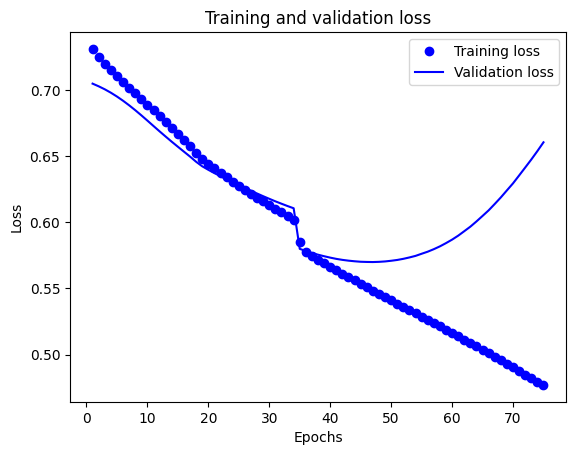

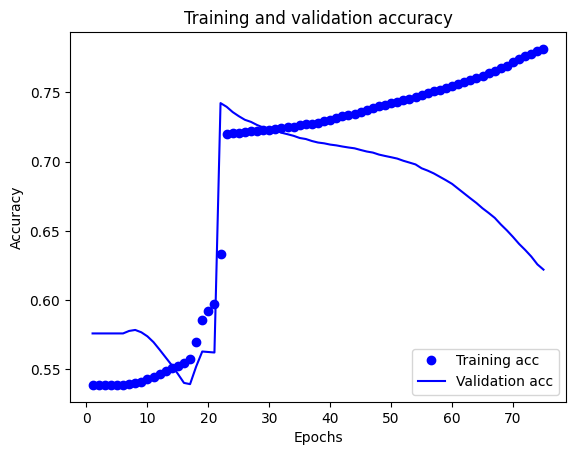

In [14]:
history_dict = history.history
history_dict.keys()

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [17]:
model.load_weights('./mydata/ecgV2/0047.ckpt')
pred_clean = np.argmax(model.predict(test_clean_inp), 1)
pred_noisy = np.argmax(model.predict(test_noisy_inp), 1)

31/31 [==============================] - 0s 2ms/step


In [18]:
cm = metrics.confusion_matrix(np.append(np.zeros_like(pred_clean), np.ones_like(pred_noisy)),  np.append(pred_clean, pred_noisy))
cm/cm.sum(1, keepdims=True)

array([[0.86802539, 0.13197461],
       [0.52845528, 0.47154472]])

In comparison with the [ecgV1.ipynb](./ecgV1.ipynb) model, these results are worse.